In [1]:
print("All ok!")

All ok!


In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain.output_parsers import PydanticOutputParser

In [4]:
# create model
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
output = model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [5]:
# create embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
len(embeddings.embed_query("hi"))

768

In [6]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os 

In [7]:
ls

 Volume in drive D has no label.
 Volume Serial Number is 7E96-59C8

 Directory of d:\Agentic-2.0

06/09/2025  07:16 PM    <DIR>          .
06/08/2025  10:42 AM               529 .env
05/18/2025  10:22 AM    <DIR>          1-Pydantic
05/25/2025  08:30 AM    <DIR>          2 - Langchain Basics
06/09/2025  07:15 PM    <DIR>          3 - Langgraph
06/09/2025  08:18 PM            13,945 assignment.ipynb
06/08/2025  12:34 PM    <DIR>          data
06/08/2025  09:23 AM               298 requirements.txt
               3 File(s)         14,772 bytes
               5 Dir(s)  124,302,143,488 bytes free


In [8]:
loader=DirectoryLoader("data",glob="./*.pdf",loader_cls=PyPDFLoader)
docs = loader.load()

In [9]:
docs[0]

Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, page_content="President of the Republic of India\nBhārata kē Rā ṣṭ rapati\nLogo of the President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince 25 July 2022\nHead of state of the Republic of India\nExecutive branch of the Indian Government\nStyle Hon'ble President\n(within India)[1]\nPresident of India\nThe president of India (ISO: Bhārata kē Rā ṣṭ rapati)\nis the head of state of the Republic of India. The\npresident is the nominal head of the executive,[a] the\nfirst citizen of the country, and the supreme\ncommander of the Indian Armed Forces. Droupadi\nMurmu is the 15th and current pres

In [10]:
## Get the source
docs[0].metadata["source"]

'data\\President_of_India.pdf'

In [11]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [12]:
new_docs=text_splitter.split_documents(documents=docs)
new_docs

[Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, page_content='President of the Republic of India\nBhārata kē Rā ṣṭ rapati\nLogo of the President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince 25 July 2022\nHead of state of the Republic of India'),
 Document(metadata={'producer': 'Skia/PDF m135', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/135.0.0.0 Safari/537.36', 'creationdate': '2025-06-08T07:04:03+00:00', 'title': 'President of India - Wikipedia', 'moddate': '2025-06-08T07:04:03+00:00', 'source': 'data\\President_of_India.pdf', 'total_pages': 24, 'page': 0, 'page_label': '1'}, pag

In [13]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [14]:
class QuerySelectionParser(BaseModel):
    Query:str=Field(description="selected query")
    Reasoning:str=Field(description='Reasoning behind query selection')

In [15]:
parser=PydanticOutputParser(pydantic_object=QuerySelectionParser)

In [16]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Query": {"description": "selected query", "title": "Query", "type": "string"}, "Reasoning": {"description": "Reasoning behind query selection", "title": "Reasoning", "type": "string"}}, "required": ["Query", "Reasoning"]}\n```'

In [17]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [18]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Related to President of India, Not Related to President of India]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Query]}

In [19]:
state1={"messages":["who is the president?"]}
function_1(state1)

Question who is the president?
Parsed response: Query='Related to President of India' Reasoning='The query "who is the president?" is ambiguous but can refer to the President of India in an Indian context.'


{'messages': ['Related to President of India']}

In [20]:
state2 = {"messages":["who is Narendra Modi?"]}
function_1(state2)

Question who is Narendra Modi?
Parsed response: Query='Not Related to President of India' Reasoning='Narendra Modi is the Prime Minister of India, not the President.'


{'messages': ['Not Related to President of India']}

In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [22]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [23]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api_key = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearchResults(tavily_api_key=tavily_api_key)

tavily_tool.invoke({"query": "What happened in RCB victory parade?"})

[{'title': '11 Dead In RCB Victory Parade Stampede - YouTube',
  'url': 'https://www.youtube.com/watch?v=kgwctnQYZIM',
  'content': "### Description\n3644 views\nPosted: 5 Jun 2025\nA stampede at the Royal Challengers Bangaluru (RCB) victory parade resulted in 11 deaths. Sources reveal that police had warned against holding the event on a weekday and had not given permission. RCB announced the parade and free entry without police consultation, leading to a massive crowd of nearly 8 lakh people overwhelming the 1,000 deployed policemen. The event's organization and lack of proper permissions are now under scrutiny. [...] victory parade is happening. It created euphoria amongst the fans. RCB did not consult the police before tweeting on the victory parade and that went viral. that had all these fans line up and queue up outside the Chinaswami stadium where it was far from a queue because it was a crowd that led to a stampede. The Bangalore police also then called up the RCB and said that

In [25]:
# WebSearch Function
def function_4(state:AgentState):
    print("-> WebSearch Call ->")
    
    question = state["messages"][0]
    
    search_results = tavily_tool.invoke({"query": question})

    # Summarize search results or use them as context for the LLM
    search_prompt = f"""Based on the following search results, answer the user's question. If the results are not conclusive, indicate that.

    Search Results:
    {search_results}

    User Question: {question}
    """

    response = model.invoke([HumanMessage(content=search_prompt)])
    return {"messages": [AIMessage(content=response.content)], "final_answer": response.content}

In [26]:
def router(state: AgentState) -> str:
    print("-> ROUTER ->")

    last_message = state["messages"][-1]
    print("last_message:", last_message)

    if "president of india" in last_message.lower():
        return "RAG Call"
    elif "latest news" in last_message.lower():
        return "WebSearch Call"
    else:
        return "LLM Call"

In [27]:
from langgraph.graph import StateGraph,END
from IPython.display import Image, display

In [28]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("WebSearch", function_4)

In [29]:
workflow.set_entry_point("Supervisor")

In [30]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WebSearch Call": "WebSearch",
    }
)

In [31]:
# All specialized nodes lead to the END point
workflow.add_edge("RAG", END)
workflow.add_edge("WebSearch", END)
workflow.add_edge("LLM", END)

app = workflow.compile()

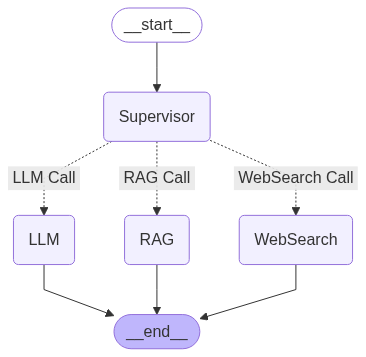

In [32]:
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
state1={"messages":["How president is elected in India?"]}
state2 = {"messages": ["what is the latest news on RCB?"]}
state3 = {"messages": ["Did KKR victory parade took place?, and how many times KKR won IPL?"]}
state4 = {"messages": ["Who is the current president, is it a he or she and when it got elected?"]}
state5 = {"messages": ["What is Machine Learning and its types?"]}

In [34]:
result = app.invoke(state1)
result

Question How president is elected in India?
Parsed response: Query='Related to President of India' Reasoning='The query explicitly asks about the election process of the President of India.'
-> ROUTER ->
last_message: Related to President of India
-> RAG Call ->


{'messages': ['How president is elected in India?',
  'Related to President of India',
  'In India, the president is indirectly elected by an electoral college.  This college comprises members of parliament (MPs) and members of state legislative assemblies (MLAs).  The MPs and MLAs generally vote for the candidate supported by their respective parties.']}

In [35]:
result = app.invoke(state2)
result

Question what is the latest news on RCB?
Parsed response: Query='what is the latest news on RCB?' Reasoning='The query is about RCB (Royal Challengers Bangalore), a cricket team, which is not related to the President of India.'
-> ROUTER ->
last_message: what is the latest news on RCB?
-> WebSearch Call ->


{'messages': ['what is the latest news on RCB?',
  'what is the latest news on RCB?',
  AIMessage(content='The latest news on RCB (Royal Challengers Bangalore) is that they are involved in a legal battle.  Following a stampede at the M. Chinnaswamy Stadium after their IPL title win on June 4th, 2025, RCB, along with event organizers and the Karnataka State Cricket Association, are facing a criminal case.  RCB has moved the Karnataka High Court to quash this case, arguing they were falsely implicated.  The marketing head of RCB also challenged his arrest in relation to the incident.  There are reports suggesting the BCCI may ban RCB from the IPL for a year if found guilty of negligence leading to the stampede.', additional_kwargs={}, response_metadata={})]}

In [36]:
result = app.invoke(state3)
result

Question Did KKR victory parade took place?, and how many times KKR won IPL?
Parsed response: Query='Not Related to President of India' Reasoning="The query is about Kolkata Knight Riders (KKR)'s IPL victories and victory parade, which are unrelated to the President of India."
-> ROUTER ->
last_message: Not Related to President of India
-> RAG Call ->


{'messages': ['Did KKR victory parade took place?, and how many times KKR won IPL?',
  'Not Related to President of India',
  "This document does not contain information about KKR or the IPL.  Therefore, I don't know if a KKR victory parade took place or how many times they won the IPL."]}

In [37]:
result = app.invoke(state4)
result

Question Who is the current president, is it a he or she and when it got elected?
Parsed response: Query='Related to President of India' Reasoning='The query explicitly asks about the current president, their gender, and election date, all of which are directly related to the office of the President of India.'
-> ROUTER ->
last_message: Related to President of India
-> RAG Call ->


{'messages': ['Who is the current president, is it a he or she and when it got elected?',
  'Related to President of India',
  'The current president of India is Droupadi Murmu, a she.  She was elected and assumed office on July 25, 2022.']}

In [41]:
result = app.invoke(state5)
result

Question What is Machine Learning and its types?
Parsed response: Query='What is Machine Learning and its types?' Reasoning='The query is about Machine Learning, a topic unrelated to the President of India.'
-> ROUTER ->
last_message: What is Machine Learning and its types?
-> LLM Call ->


{'messages': ['What is Machine Learning and its types?',
  'What is Machine Learning and its types?',
  "Machine learning (ML) is a branch of artificial intelligence (AI) that focuses on enabling computer systems to learn from data without being explicitly programmed.  Instead of relying on pre-defined rules, ML algorithms identify patterns, make predictions, and improve their performance over time based on the data they are exposed to.  Think of it as teaching a computer to learn like a human does, through experience.\n\nThere are several ways to categorize the types of machine learning, but the most common distinctions are:\n\n* **Supervised Learning:** This is the most common type.  The algorithm is trained on a labeled dataset, meaning each data point is tagged with the correct answer or outcome.  The algorithm learns to map inputs to outputs based on this labeled data.  Examples include:\n\n    * **Regression:** Predicting a continuous value (e.g., predicting house prices based on